## Lab 1: Building AI Agents

### Overview
This notebook provides a comprehensive introduction to Strands Agents, a framework for building intelligent agents that can perform complex tasks using tools, models, and integrations. We will explore how to create and configure agents, implement custom tools, and leverage advanced features such as browser automation, code interpretation, event callbacks, and structured output extraction.

### Use-case scenarios
The notebook will demonstrate a number of use-case scenarios for Strands Agents within a Know-Your-Customer (KYC) verification context. KYC is a challenging real-world use-case that requires gathering and analyzing data from multiple sources, making it an ideal scenario to showcase the capabilities of Strands Agents. Examples of what a KYC agent might do include:
- Verifying and processing documentation provided by the customer
- Obtaining data from various APIs (e.g., credit reports, income verification, property ownership, lien information)
- Gathering data from web sources such as county records
- Finding any adverse media or negative news about the customer

Normally these tasks would require significant manual effort and time, but with GenAI agents, much of this work can be automated, leading to faster and more accurate outcomes and greater customer satisfaction.

### Goals
- Introduce Strands Agents and the core concepts (system prompt, model, tools).
- Implement a simple custom tool (OpenStreetMap Nominatim geocoder).
- Use AgentCore browser and code interpreter tools to perform web scraping and code execution.
- Generate and query synthetic KYC data and wire a session memory integration.

### Key tools & libraries covered
- [Strands Agent framework](https://strandsagents.com/latest/)
- [AgentCore Browser integration](https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/browser-tool.html)
- [AgentCore Code Interpreter](https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/code-interpreter-tool.html)
- [Strands community tools](https://github.com/strands-agents/tools?tab=readme-ov-file)
- [Pydantic for structured outputs](https://strandsagents.com/latest/documentation/docs/user-guide/concepts/agents/structured-output/)
- [AgentCore Memory integration](https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/memory.html)

### Workshop repo organization
The notebooks will guide through all the steps required to build and deploy AI agents using Strands and AgentCore, however if you want to explore the code and materials directly, you can use the following structure as a reference for how the workshop repository is organized:
```
|-- 01_strands_intro.ipynb                  <--- Lab 1: Building AI Agents with Strands and AgentCore
|-- 02_agentcore_tool_deployment.ipynb      <--- Lab 2: Tools Deployment, AgentCore Identity, and AgentCore Gateway Integration
|-- 03_agentcore_agent_deployment.ipynb     <--- Lab 3: Agent Deployment and AgentCore Gateway Integration
|-- 04-cleanup.ipynb                        <--- Lab 4: Cleanup Resources created during the workshop
|-- CODE_OF_CONDUCT.md
|-- LICENSE
|-- Makefile
|-- README.md
|-- helpers                                 <--- Helper directory contains utility scripts used across the labs (generating data, gif creation, etc.)
|   |-- __init__.py
|   |-- generate_workshop_data.py
|   `-- gif_helper.py
|-- requirements.txt
`-- workspace                               <--- Workspace directory contains the custom tools and agent implementations that will be deployed on remote runtimes
    |-- __init__.py
    |-- kyc_agent                           <--- Contains the code for the KYC agent implementation
    |   |-- kyc_agent.py
    |   `-- requirements.txt
    `-- kyc_tools                           <--- Contains custom tools for KYC data querying and MCP server integration
        |-- __init__.py
        |-- kyc_data_tools.py
        |-- mcp_server.py
        `-- requirements.txt


In [1]:
%pip install -Uq -r requirements.txt 2> /dev/null && echo "All required packages are installed."

All required packages are installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime as dt
import json
import sys
import boto3
import botocore
import subprocess
from uuid import uuid4
from pathlib import Path

import requests
from rich import print as rprint
from rich.markdown import Markdown, Syntax

from pydantic import BaseModel, Field

# core strands imports for building agents
from strands import Agent, tool
from strands.models import BedrockModel

# Hook imports for customizing agent behavior via event callbacks
from strands.experimental.hooks import AfterToolInvocationEvent
from strands.hooks import HookProvider, HookRegistry

# AgentCore tool integrations for browser automation and code interpretation
from strands_tools.browser import AgentCoreBrowser
from strands_tools.browser.models import BrowserInput, ScreenshotAction
from strands_tools.code_interpreter import AgentCoreCodeInterpreter

# calculator tool from strands community tools
from strands_tools.calculator import calculator


### Configuring Our First Agent: Primary Residence Mortgage Eligibility Verification

Getting started with Strands Agents is straightforward. We simply need to configure:
- The **system prompt** to define the agent's role and behavior.
- The **model** to be used (e.g., Anthropic Claude, Amazon Nova, etc.).
- The **tools** the agent can use to perform its tasks

To demonstrate the capabilities of Strands Agents, we will configure an agent to verify a customer's eligibility for a primary residence mortgage. Properties that are primary residences typically have lower interest rates and more favorable terms compared to investment properties or second homes. As part of the verification process, the agent will utilize geocoding tools to determine the proximity of the property to the customer's workplace, which is a common requirement for primary residence loans.

Let's start by defining the model we will use for our agent.

Here, we are using **Anthropic Claude Haiku 4.5 via Amazon Bedrock** but other models and providers are supported as well.

In [3]:
REGION = boto3.Session().region_name
MODEL =  BedrockModel(
    model_id="global.anthropic.claude-haiku-4-5-20251001-v1:0",
    temperature=0.0, # we set the temperature to 0 for more deterministic outputs. Increase for more randomness.
)

Next we will create a custom tool that uses the OpenStreetMap Nominatim API to geocode addresses. This is simply done by decorating a python function with `@tool` decorator provide by strands. The docstring of the function will be used by the agent to understand how to use the tool. Note that the docstring should be in a [Google-style format](https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_google.html) to be parsed correctly by strands.

In [4]:
@tool
def get_address_info(address_query: str, country_code: str = "US", limit=5) -> dict:
    """
    Retrieves address information using the Nominatim API.

    Args:
        address_query (str): The address to search for.
        country_code (str, optional): The country code to restrict the search. Defaults to "US".
        limit (int, optional): Maximum number of results to return. Defaults to 5.

    Returns:
        dict: A dictionary containing the address search results from Nominatim including the formatted address and geo coordinates.

    Raises:
        requests.HTTPError: If the HTTP request to the Nominatim API fails.
    """
    
    url = "https://nominatim.openstreetmap.org/search"
    
    params = {
        "q": address_query,
        "format": "json",
        "addressdetails": 1,
        "limit": limit,
        "countrycodes": country_code,
    }
    
    headers = {
        "User-Agent": "PropertyResearchBot/1.0 (contact@youremail.com)"
    }
    
    response = requests.get(url, params=params, headers=headers)
    response.raise_for_status()
    return response.json()

Next we define the system prompt and configure our agent. Note that Strands provide a number of community built tools that we can readily use. Here in addition to the custom geocoding tool, we will provide a built-in calculator tool that the agent can use to compute the estimated distances between the geocoded addresses.

In [5]:
PRIMARY_RESIDENCE_MORTGAGE_VERIFICATION_PROMPT = """
You are a mortgage verification agent whose job is to verify if a mortgage applicant is eligible for a primary residence mortgage.
In order to qualify for a primary residence mortgage, the applicant must meet the following criteria:
1. The property must be in the same country as the applicant's job location.
2. The property must be within 30 miles of the applicant's job location. Euclidean distance is acceptable for this calculation.
3. The applicant must not own any other properties.

Use the tools at your disposal to gather the necessary information to make a decision.
"""

primary_residence_verification_agent = Agent(
    model=MODEL,
    tools=[get_address_info, calculator],
    system_prompt=PRIMARY_RESIDENCE_MORTGAGE_VERIFICATION_PROMPT,
)
# Example usage
# You can try replacing Venetian Las Vegas with Venice, Italy to see how the agent responds.

mortgage_verification_prompt = """
The applicant's work location is Venetian Las Vegas and they are applying for a mortgage at 2928 Coast Line Ct, Las Vegas, NV 89117.
"""
mortgage_verification_response = primary_residence_verification_agent(mortgage_verification_prompt)


I'll help you verify if this applicant is eligible for a primary residence mortgage. Let me gather the necessary information about both locations.
Tool #1: get_address_info

Tool #2: get_address_info
Great! I found both locations. Now let me calculate the distance between them using the coordinates:

- **Venetian Las Vegas**: Latitude 36.1217073, Longitude -115.1693352
- **2928 Coast Line Ct, Las Vegas, NV 89117**: Latitude 36.1373712, Longitude -115.2879006

Let me calculate the Euclidean distance:
Tool #3: calculator


╭────────────────────────────────────────────── Calculation Result ───────────────────────────────────────────────╮
│                                                                                                                 │
│  ╭───────────┬──────────────────────────────────────────────────────────────────────────────╮                   │
│  │ Operation │ Evaluate Expression                                                          │                   │
│  │ Input     │ sqrt((36.1373712 - 36.1217073)**2 + (-115.2879006 - (-115.1693352))**2) * 69 │                   │
│  │ Result    │ 8.25                                                                         │                   │
│  ╰───────────┴──────────────────────────────────────────────────────────────────────────────╯                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Perfect! Now let me provide you with the verification results:

## Mortgage Eligibility Verification

**Applicant Information:**
- Work Location: Venetian Las Vegas (3355 South Las Vegas Boulevard, Paradise, NV 89109)
- Property Address: 2928 Coast Line Ct, Las Vegas, NV 89117

### Eligibility Criteria Assessment:

✅ **Criterion 1: Same Country**
- Work location country: United States
- Property country: United States
- **Status: PASS**

✅ **Criterion 2: Within 30 Miles of Job Location**
- Distance calculated: **8.25 miles**
- Maximum allowed: 30 miles
- **Status: PASS**

⚠️ **Criterion 3: No Other Properties Owned**
- **Status: UNABLE TO VERIFY** - This information was not provided. You will need to confirm with the applicant that they do not own any other properties.

### Conclusion:

**The applicant meets 2 out of 3 criteria.** The property is in the same country as the job location and is well within the 30-mile radius requirement (only 8.25 miles away). 

**To complete the verific

### AgentCore Browser, AgentCore Code Interpreter, Event Hooks, and Structured Outputs

Now that we have seen how to create a simple agent with custom tools, let's explore a more complex use-case. We will create a property research agent that will utilize the AgentCore Browser to gather information about a property from public records. The agent will then generate code to extract data from the web pages it visits and use AgentCore's code interpreter tool to execute the code. We will also explore additional Strands Agents features such as event hooks that we can use to modify the agent's execution flow and structured outputs to generate outputs based on a defined json schema.

First let's create a data model that defines the structured output schema for the property research agent containing fields that we want the agent to gather about the property.

In [6]:
# we can use the Pydantic Library to define a structured output schema
# this will allow us to extract structured data from the agent's response that is easier to consume for downstream applications
class PropertyInfo(BaseModel):
    address: str = Field(..., description="The full address of the property.")
    parcel_identifier: str = Field(..., description="The parcel identifier of the property.")
    land_size_sqft: int = Field(..., description="The land size in square feet.")
    building_size_sqft: int = Field(..., description="The building size in square feet.")
    livable_area_sqft: int = Field(..., description="The livable area in square feet including finished basements.")
    year_built: int = Field(..., description="The year the property was built.")
    construction_type: str = Field(..., description="The type of construction of the property.")
    roof_type: str = Field(..., description="The type of roof on the property.")
    has_pool: bool = Field(..., description="Indicates if the property has a pool.")
    number_of_fireplaces: int = Field(..., description="The number of fireplaces in the property.")
    assessed_value: float = Field(..., description="The assessed value of the property.")
    taxable_value: float = Field(..., description="The taxable value of the property.")
    annual_property_tax: float = Field(..., description="The annual property tax amount.")

As agents perform more complex tasks, it is often useful to have visibility into their internal operations, or modify its behavior midstream. For example we may want to log certain events, or even interrupt them to review intermediate results before having the agent proceed.
We can use life-cycle [event hooks](https://strandsagents.com/latest/documentation/docs/user-guide/concepts/agents/hooks/) provided by strands for this exact purpose. Here we will define an event hook that will be called after each tool invocation. We won't modify any of the agent behavior in this example, but we will simply display the generated code when the code interpreter tool is invoked and take screenshot of the browser whenever a browser action is performed which can be useful for debugging.

In [7]:
class DisplayHooks(HookProvider):
    
    def __init__(self, screenshot_path: str = "."):
        self.screenshot_path = screenshot_path
    
    def register_hooks(self, registry: HookRegistry) -> None:
        # register the callbacks for after tool invocation event
        registry.add_callback(AfterToolInvocationEvent, self.take_screenshot)
        registry.add_callback(AfterToolInvocationEvent, self.print_code_execution)

    def take_screenshot(self, event: AfterToolInvocationEvent) -> None:
        
        "Takes a screenshot after each browser tool use"
        try:
            if event.tool_use.get("name") == "browser":

                date_suffix = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
                screenshot_path = f"{self.screenshot_path}/screenshot_{date_suffix}.png"

                # get the browser session name
                session_name = event.tool_use.get("input", {}).get("browser_input", {}).get("action", {}).get("session_name", "default")
                browser_tool = event.selected_tool
                

                action = ScreenshotAction(type="screenshot", session_name=session_name, path=screenshot_path)
                # browser_tool.screenshot(action)
                browser_input = BrowserInput(action=action)
                
                browser_tool = event.selected_tool
                try:
                    browser_tool(browser_input) # type: ignore
                except Exception as e:
                    print(f"Could not take screenshot {e}")
        except Exception as e:
            print(f"Could not take screenshot due to {e}")
                
    def print_code_execution(self, event: AfterToolInvocationEvent) -> None:
        "Prints the code execution results after each code interpreter tool use"
        try:
            if event.tool_use.get("name") == "code_interpreter":
                code_interpreter_input = event.tool_use.get("input", {}).get("code_interpreter_input", {}).get("action", {})
                
                if code_interpreter_input.get("type") == "executeCode":
                    rprint("Code Interpreter executed code:")
                    rprint(Syntax(code_interpreter_input["code"], "python", line_numbers=True, theme="lightbulb"))
                    
                elif code_interpreter_input.get("type") == "executeCommand":
                    rprint("Code Interpreter executed command:")
                    rprint(Syntax(code_interpreter_input["command"], "shell", line_numbers=True, theme="lightbulb"))
        except Exception as e:
            print(f"Could not print code due to {e}")


For this example, we'd want the agent to navigate to a county property records website, search for the property, and extract relevant details such as assessed value, property taxes, and any liens on the property. We can provide detailed instructions to the agent in the system prompt giving it context on how to go about its task and injecting the schema for the structured output we want it to generate at the end of its research.

In [8]:
# convert the PropertyInfo model fields to a bulleted list for inclusion in the system prompt
property_data_fields = "\n - ".join([f"field_{field[0]}: {field[1].description}" for field in PropertyInfo.model_fields.items()])

PROPERTY_RESEARCH_PROMPT = f"""
You are a building research agent. Your job is to get information about a specific building in Clark County, Nevada.
Only use the official Clark County website (https://maps.clarkcountynv.gov/assessor/AssessorParcelDetail/site.aspx) to research the property.
Do not use any other websites.
Decompose the address into its components (street number, street name, street type, city) and enter these into the form on the website.
Use the following html element ids to fill in the form:
- Street Number: txtNumber
- Street Name: txtName
- Street Type: lstType   (Check the dropdown options to find the correct one)
- City: lstCity  (Check the dropdown options to find the correct one)
- Search Button: btnSubmit

The search results will be container in a table with the id "gvList". 
The third column contains the parcel identifier link which you can click to access the property details page.

Do not try to parse the html content of the property details page.
Instead extract all of the text content from the property details page and use it to find the information you need.

Gather the following information about the property:
{property_data_fields}

Use the code interpreter tool to perform any calculations on the extracted values.
To compute the annual tax rate multiply the assessed value by 0.0056
"""

We can now configure the Agent to use the [Browser](https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/browser-tool.html) and [Code Interpreter](https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/code-interpreter-tool.html) tools that it can use to interact with the UI and write code to extract the data we're looking for. While we will be using a screenshot based mechanism to review the browser actions, AgentCore Browser offers more [robust replay capabilities](https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/browser-session-replay.html) that interact witrh the browser DOM directly.

<div style="padding: 15px; margin: 10px 0; border-left: 4px solid #ffc107; background-color: #fff3cd; color: #141001ff;">
    <strong>⚠️ WARNING:</strong> UI interaction is a developing feature and the example below might not run or complete successfully. Feel free to rerun the cell if an issue occurs but otherwise proceed to the next section as the rest of the lab does not depend on this section.
</div>

I'll help you find information about the property at 2928 Coast Line Ct, Las Vegas, NV 89117. Let me start by initializing a browser session and navigating to the Clark County assessor website.
Tool #1: browser
Now let me navigate to the Clark County assessor website:
Tool #2: browser
Let me take a screenshot to see the form:
Tool #3: browser
Now I'll fill in the form with the address components. The address is 2928 Coast Line Ct, Las Vegas, NV 89117, so:
- Street Number: 2928
- Street Name: Coast Line
- Street Type: Ct (Court)
- City: Las Vegas

Let me start by entering the street number:
Tool #4: browser

Tool #5: browser
Now let me enter the street name:
Tool #6: browser

Tool #7: browser
Now let me check the street type dropdown to find "Ct":
Tool #8: browser

Tool #9: browser
Perfect! I can see "CT" is the value for "Court". Let me select it:
Tool #10: browser
Now let me check the city dropdown to find "Las Vegas":
Tool #11: browser

Tool #12: browser
Great! I can see "LAS VEGAS" 

Code Interpreter executed code:

  1 # Calculate annual property tax                                                                                
  2 # Assessed value for 2026-27 fiscal year                                                                       
  3 assessed_value = 1081503                                                                                       
  4 tax_rate = 0.0056                                                                                              
  5                                                                                                                
  6 annual_tax = assessed_value * tax_rate                                                                         
  7 print(f"Assessed Value: ${assessed_value:,.2f}")                                                               
  8 print(f"Tax Rate: {tax_rate}")                                                                                 
  9 print(f"Annual Property Tax: ${annual_tax:,.2f}")                                                              

Perfect! I've gathered all the information about the property at 2928 Coast Line Ct, Las Vegas, NV 89117. Here's the complete property information:

## Property Information for 2928 Coast Line Ct, Las Vegas, NV 89117

**field_address:** 2928 COAST LINE CT, LAS VEGAS, NV

**field_parcel_identifier:** 163-08-611-017

**field_land_size_sqft:** 23,087 sq ft (0.53 acres)

**field_building_size_sqft:** 11,213 sq ft (1st Floor: 4,579 + 2nd Floor: 6,025 + Carport: 552 + Garage: 999 + Basement Garage: 0)

**field_livable_area_sqft:** 11,662 sq ft (includes finished basement of 1,058 sq ft)

**field_year_built:** 1991

**field_construction_type:** Frame-Brick Veneer

**field_roof_type:** Clay Tile/Slate

**field_has_pool:** YES

**field_number_of_fireplaces:** 2

**field_assessed_value:** $1,081,503 (2026-27 fiscal year)

**field_taxable_value:** $3,090,009 (2026-27 fiscal year)

**field_annual_property_tax:** $6,056.42

Additional details:
- Style: Two Story
- Bedrooms: 6
- Bathrooms: 5 Full
- 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                 Browser Replay                                                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

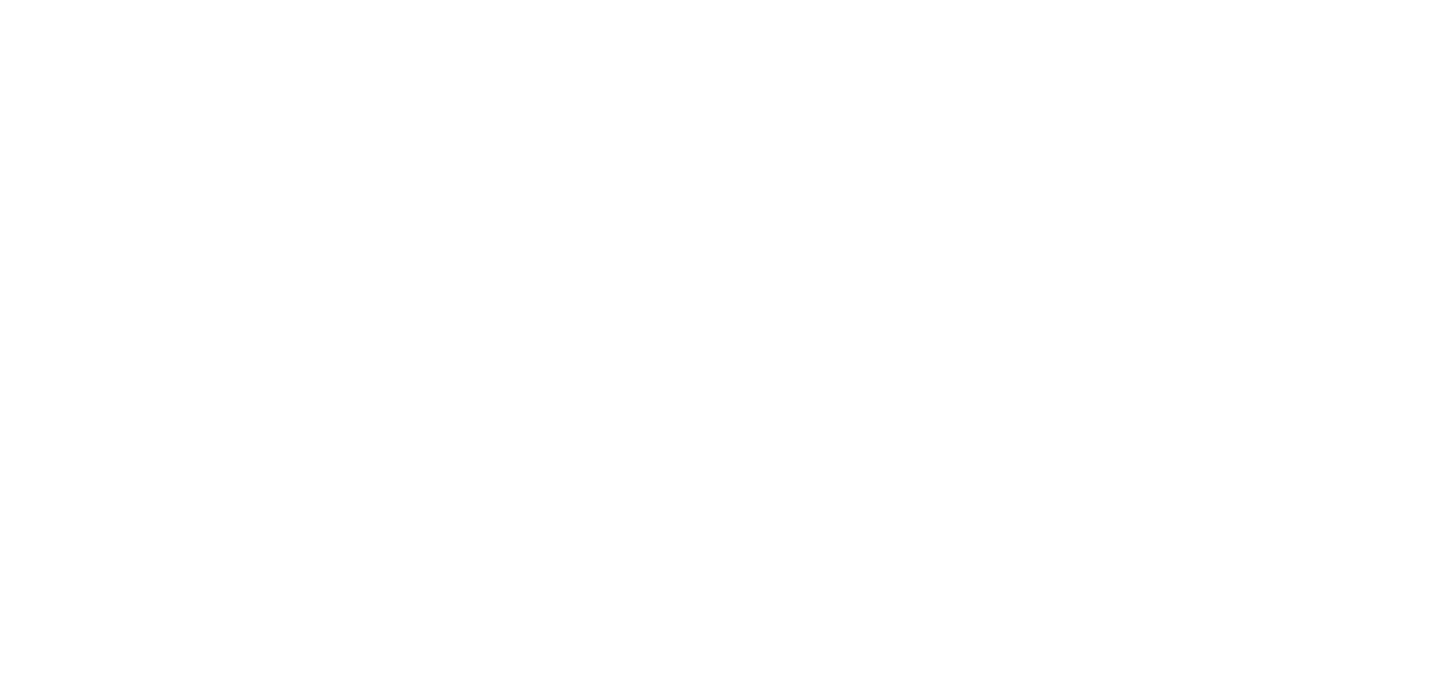


Tool #23: PropertyInfo


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Final Result                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

                                                                                                                   
 {                                                                                                                 
   "address": "2928 COAST LINE CT, LAS VEGAS, NV 89117",                                                           
   "parcel_identifier": "163-08-611-017",                                                                          
   "land_size_sqft": 23087,                                                                                        
   "building_size_sqft": 11213,                                                                                    
   "livable_area_sqft": 11662,                                                                                     
   "year_built": 1991,                                                                                             
   "construction_type": "Frame-Brick Veneer",                                                                      
   "roof_type": "Clay Tile/Slate",                                                                                 
   "has_pool": true,                                                                                               
   "number_of_fireplaces": 2,                                                                                      
   "assessed_value": 1081503.0,                                                                                    
   "taxable_value": 3090009.0,                                                                                     
   "annual_property_tax": 6056.42                                                                                  
 }                                                                                                                 
                                                                                                                   

In [10]:
from helpers.gif_helper import pngs_to_gif

# create the browser and code interpreter tools using the provided AgentCore wrappers
browser = AgentCoreBrowser(region=REGION)
code_interpreter = AgentCoreCodeInterpreter(region=REGION)


PROPERTY = "2928 Coast Line Ct, Las Vegas, NV 89117"

date_dir = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
screenshot_path = f"browser_screenshots/screenshot_{date_dir}"

# create the agent with browser and code interpreter tools
browser_agent = Agent(
        model=MODEL,
        system_prompt=PROPERTY_RESEARCH_PROMPT,
        tools=[browser.browser, code_interpreter.code_interpreter],
        hooks=[DisplayHooks(screenshot_path=screenshot_path)]
)

try:
        # invoke agent to research property
        browser_agent(f"Find information about the property at {PROPERTY}")

        # cleanup resources
        browser.close_platform()
        code_interpreter.cleanup_platform()
        
        
        # replay screenshots as gif
        rprint(Markdown(f"# Browser Replay \n"))
        pngs_to_gif(f"screenshots/{screenshot_path}", output_path="screenshots/animation.gif", fps=6, show=True)

        # convert to final structured output
        property_info = browser_agent.structured_output(PropertyInfo)
        rprint(Markdown(f"# Final Result \n```json\n{property_info.model_dump_json(indent=2)}\n```"))
        
except Exception as e:
        rprint(f"[red]Error occurred during agent execution: {e}[/red]\nTry running the cell again or proceed with the lab.")

### Know Your Customer (KYC) Research Agent
Now that we have seen how to build and customize agents with Strands, let's explore a more practical example that we will also build upon for the remainder of the workshop. We will create a KYC Research Agent that can perform a series of tasks to gather and analyze information about a customer. This agent will utilize multiple tools, to research the customer's credit history, verify their income, check property ownership, and look for any existing liens and judgments.

To simulate a more realistic scenario, we will generate some mock customer data. Details about the customer such as their name and address have been perturbed across datasets to make it more challenging to gather accurate information across various sources. For example, a customer's name may or may not include a middle initial or names may vary across datasets (e.g. William, Bill, Will), and their address may have slight variations in formatting (st. vs street).

Normally this challenge is tackled through a combination of manual research ands sophisticated data matching and entity resolution algorithms, but here we will rely on the agent's ability to reason and use tools to gather the necessary information.

The code below will generate the synthetic customer data in json-lines format.

In [12]:
# generate synthetic data
subprocess.run([sys.executable, "helpers/generate_workshop_data.py"], check=True)

Generating synthetic data for 1000 individuals...
Generation complete. Converting to DataFrames and saving json-lines files...

Successfully created 4 JSON files:
 - synthetic_credit_reports.json (1000 rows)
 - synthetic_income_verification.json (1000 rows)
 - synthetic_property_records.json (722 rows)
 - synthetic_lien_records.json (125 rows)


CompletedProcess(args=['/opt/conda/bin/python', 'helpers/generate_workshop_data.py'], returncode=0)

To query the data, a helper `KYCQueryEngine` class has been implemented. The class allows querying the data through a fuzzy search mechanism using BM25 as well as key-value lookups based on a unique identifier. You can find the implementation of the `KYCQueryEngine` here [workspace/kyc_tools/kyc_data_tools.py](workspace/kyc_tools/kyc_data_tools.py).

[BM25](https://en.wikipedia.org/wiki/Okapi_BM25) is a ranking function commonly used by search engines to estimate the relevance of documents to a given search query. It works by considering factors such as term frequency (how often a term appears in a document), inverse document frequency (how common or rare a term is across all documents), and document length normalization. In this example, a document refers to either a customer name or address. The terms are character n-grams extracted from the names and addresses and are indexed to enable fuzzy search capabilities. For example if the document "Spring st" is indexed using character 3-grams, the following terms would be created: "Spr", "pri", "ing", "ng ", "g s", " st". Then fuzzy search queries can be performed by the agent to retrieve relevant records that have the most overlapping n-grams with the search query.

In [13]:
# KYCQueryEngine provides key value access and wildcard search over structured json data
from workspace.kyc_tools import KYCQueryEngine

# files containing synthetic data
synthetic_data_path = Path("synthetic_data")
credit_report_data = synthetic_data_path / "synthetic_credit_reports.json"
income_verification_data = synthetic_data_path / "synthetic_income_verification.json"
property_records_data = synthetic_data_path / "synthetic_property_records.json"
lien_records_data = synthetic_data_path / "synthetic_lien_records.json"

# index the data for querying
credit_report_data_query_engine = KYCQueryEngine.from_json_lines(
    credit_report_data,
    text_fields_to_index=["full_legal_name", "primary_address"],    # we index name and address for text search
    unique_id_field="government_id",                                # data can also be queried by government id
)

income_verification_data_query_engine = KYCQueryEngine.from_json_lines(
    income_verification_data,
    text_fields_to_index=["employee_name"],
    unique_id_field="government_id",
)

property_records_data_query_engine = KYCQueryEngine.from_json_lines(
    property_records_data,
    text_fields_to_index=["owner_name_on_deed", "property_address"],
    unique_id_field="property_id",
)

lien_records_data_query_engine = KYCQueryEngine.from_json_lines(
    lien_records_data,
    text_fields_to_index=["debtor_name", "debtor_address"],
    unique_id_field="lien_id",
)

We can test the fuzzy search functionality of the `KYCQueryEngine` by searching for a customer name. The tool will return multiple results but our agent will be able to reason about which one is the most likely match based on additional context such as the address.

In [14]:
# test fuzzy search
rprint(credit_report_data_query_engine.query_bm25("K Mckdonald", query_field="full_legal_name", top_n=3)[0])

{
    'government_id': '433-77-1041',
    'full_legal_name': 'Kyle Mcdonald',
    'date_of_birth': -104198400000,
    'primary_address': '184 Rodriguez Mews, South Aaron, VA 94830',
    'credit_score': 534,
    'account_tradelines': [
        {
            'account_type': 'HELOC',
            'balance': 78925.1,
            'monthly_payment': 657.71,
            'credit_limit': None,
            'utilization_ratio': None
        },
        {
            'account_type': 'Auto Loan',
            'balance': 31390.03,
            'monthly_payment': 442.11,
            'credit_limit': None,
            'utilization_ratio': None
        }
    ]
}

To use the `KYCQueryEngine` in our agent, we need to convert the query methods into Strands tools. This can be done by wrapping the `KYCQueryEngine` methods with the `@tool` decorator. However, since the methods were defined in a separate module, we can use `@tool` as a function that takes the `KYCQueryEngine` methods as arguments achieving the same effect.

In [15]:
# convert the query engine methods into tools
# Note that tool() is the same as the @tool decorator but used as a function wrapper 
# This is useful when you want to create a tool from an existing function or method without modifying its definition

credit_score_search_tool = tool(
    credit_report_data_query_engine.query_bm25,
    name="credit_report_search",
    # we can manually specify the description instead of using the function's docstring
    description="Search credit report data by fields 'full_legal_name' or 'primary_address'",  
)  # type: ignore

income_verification_search_tool = tool(
    income_verification_data_query_engine.query_bm25,
    name="income_verification_search",
    description="Search income verification data by fields 'employee_name'",
)  # type: ignore

property_records_search_tool = tool(
    property_records_data_query_engine.query_bm25,
    name="property_records_search",
    description="Search property records data by fields 'owner_name_on_deed' or 'property_address'",
)  # type: ignore

lien_records_search_tool = tool(
    lien_records_data_query_engine.query_bm25,
    name="lien_records_search",
    description="Search lien records data by fields 'debtor_name' or 'debtor_address'",
)  # type: ignore

### Session persistence with AgentCore Memory

Now that we have the data indexed and query tools defined, we can configure our KYC Research Agent. But before we do that, let's explore how we can enable session persistence for our agent using AgentCore Memory.

By default, Strands Agents maintain an in-memory history of the agent's interactions during a session. However, this memory is ephemeral and will be lost once the agent session ends. To enable persistent memory that can be retained across agent interactions, we can integrate Strands Agents with [AgentCore Memory](https://strandsagents.com/latest/documentation/docs/community/session-managers/agentcore-memory/). Here we will only use short term memory persistence which will store messages for the current session. AgentCore Memory also supports long-term memory that can be used to store key information across sessions such as session summaries, important facts, user preferences, and more. For more details, please refer to the [AgentCore Memory documentation](https://docs.aws.amazon.com/bedrock-agentcore/latest/devguide/memory.html).

In [16]:
# additional imports for memory setup
from bedrock_agentcore.memory import MemoryClient
from bedrock_agentcore.memory.integrations.strands.config import AgentCoreMemoryConfig
from bedrock_agentcore.memory.integrations.strands.session_manager import AgentCoreMemorySessionManager


memory_client = MemoryClient(region_name=REGION)

# check if memory already exists and create if not
memory_name = "KYCAgentMemory"
existing_memories = [mem for mem in memory_client.list_memories() if memory_name in mem["id"]]

if existing_memories:
    print(f"Using existing memory: {existing_memories[0]['id']}")
    kyc_agent_memory = existing_memories[0]
else:
    print(f"Creating new memory: {memory_name}.")
    kyc_agent_memory = memory_client.create_memory(
        name=memory_name,
        description="Memory for KYC Agent storing customer interactions and retrieved data"
    )
# if memory has not been created, It may take up to 5 minutes to become active
print("Waiting for memory to become active. This may take several minutes...")
memory_client._wait_for_memory_active(kyc_agent_memory["id"], max_wait=300, poll_interval=20)

Using existing memory: KYCAgentMemory-1BcrQb90N7
Waiting for memory to become active. This may take several minutes...


{'arn': 'arn:aws:bedrock-agentcore:us-west-2:780660052610:memory/KYCAgentMemory-1BcrQb90N7',
 'id': 'KYCAgentMemory-1BcrQb90N7',
 'name': 'KYCAgentMemory',
 'description': 'Agent memory for workshop',
 'eventExpiryDuration': 7,
 'status': 'ACTIVE',
 'createdAt': datetime.datetime(2026, 2, 18, 21, 13, 36, 776000, tzinfo=tzlocal()),
 'updatedAt': datetime.datetime(2026, 2, 18, 21, 13, 39, 563000, tzinfo=tzlocal()),
 'strategies': [],
 'memoryId': 'KYCAgentMemory-1BcrQb90N7',
 'memoryStrategies': []}

We can now configure our agent with the custom KYC tools and AgentCore Memory for session persistence.

In [17]:
MEM_ID = kyc_agent_memory.get("memoryId")     # memory ID to store/retrieve memories
ACTOR_ID = f"kyc_agent_actor-{uuid4()}"       # unique actor ID for the agent (usually a combination of agent and user id)
SESSION_ID = f"kyc_agent_session-{uuid4()}"   # unique session ID for the current conversation/session

MEMORY_CONFIG = AgentCoreMemoryConfig(
    memory_id=MEM_ID,
    session_id=SESSION_ID,
    actor_id=ACTOR_ID
)

# workshop quota only allows 1 write to memory every 4 seconds
# retry attempts and backoff settings would help with transient failures during memory write operations
BOTO_CONFIG = botocore.config.Config(
    retries={
        "max_attempts": 6,
        "mode": "adaptive"
    }
)

# Create session manager that will handle storing and retrieving messages from AgentCore Memory
MEMORY_MANAGER = AgentCoreMemorySessionManager(
    agentcore_memory_config=MEMORY_CONFIG,
    region_name=REGION,
    boto_client_config=BOTO_CONFIG
)


KYC_RESEARCH_AGENT_PROMPT = """
You are a Know Your Customer research agent whose job is to gather information about mortgage applicants to help determine their mortgage eligibility.
You have access to the following tools:
1. Credit Report Search: Use this tool to search credit report data by fields 'full_legal_name' or 'primary_address'.
2. Income Verification Search: Use this tool to search income verification data by fields 'employee_name'.
3. Property Records Search: Use this tool to search property records data by fields 'owner_name_on_deed' or 'property_address'.
4. Lien Records Search: Use this tool to search lien records data by fields 'debtor_name' or 'debtor_address'.
5. Calculator: Use this tool to perform mathematical calculations, including distance calculations.

Gather the following information about the applicant:
1. Full legal name
2. Current address
3. Employment status and income
4. Credit score
5. Debt to income ratio
6. Any liens or judgments against them

Note that the applicant's name and address may be represented in different ways in different datasets. 
Use fuzzy matching and partial matches across datasets to ensure you find all relevant information.

Use the tools at your disposal to gather the necessary information to help support the mortgage verification decision.
"""

kyc_research_agent = Agent(
    model=MODEL,
    tools=[
        credit_score_search_tool,
        income_verification_search_tool,
        property_records_search_tool,
        lien_records_search_tool,
        calculator,
    ],
    system_prompt=KYC_RESEARCH_AGENT_PROMPT,
    session_manager=MEMORY_MANAGER, # add external memory persistence
)

kyc_response = kyc_research_agent("Gather information about applicant William Mcgee")

I'll gather information about William Mcgee by searching across multiple databases. Let me start with credit reports, income verification, property records, and lien records.
Tool #1: credit_report_search

Tool #2: income_verification_search

Tool #3: property_records_search

Tool #4: lien_records_search
Great! I found relevant information about William Mcgee. Now let me calculate the debt-to-income ratio based on the data I've gathered.
Tool #5: calculator


╭────────────────────────────────────────────── Calculation Result ───────────────────────────────────────────────╮
│                                                                                                                 │
│  ╭───────────┬────────────────────────────────────────────────────────────────────────────────────╮             │
│  │ Operation │ Evaluate Expression                                                                │             │
│  │ Input     │ (3980.41 + 739.41 + 275.82 + 530.82 + 493.98 + 113.23 + 803.02) / (171461.41 / 12) │             │
│  │ Result    │ 0.49                                                                               │             │
│  ╰───────────┴────────────────────────────────────────────────────────────────────────────────────╯             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## Summary of Information for William Mcgee

### Personal Information
- **Full Legal Name:** William Mcgee
- **Government ID:** 878-64-7325
- **Date of Birth:** January 1, 1956
- **Current Address:** 801 Wu Points, Lake Emily, MA 48125

### Employment Status & Income
- **Employer:** Velasquez Group
- **Verified Annual Salary:** $171,461.41
- **Monthly Income:** $14,288.45

### Credit Information
- **Credit Score:** 712 (Fair/Good)
- **Account Tradelines:**
  - Mortgage: $724,434.99 balance, $3,980.41/month
  - HELOC: $88,729.02 balance, $739.41/month
  - Auto Loan: $9,929.41 balance, $275.82/month
  - HELOC: $63,698.94 balance, $530.82/month
  - HELOC: $59,277.29 balance, $493.98/month
  - Credit Card: $2,680.42 balance, $113.23/month (27% utilization)
  - Mortgage: $277,042.17 balance, $803.02/month

### Debt-to-Income Ratio
- **Total Monthly Debt Payments:** $6,936.69
- **Monthly Income:** $14,288.45
- **Debt-to-Income Ratio:** 49% (0.49)

### Property Information
- **Property Addres

In [18]:
# print the last stored messages in memory
rprint(MEMORY_MANAGER.list_messages(session_id=SESSION_ID, agent_id=ACTOR_ID)[-1])

SessionMessage(
    message={
        'role': 'assistant',
        'content': [
            {
                'text': '## Summary of Information for William Mcgee\n\n### Personal Information\n- **Full Legal 
Name:** William Mcgee\n- **Government ID:** 878-64-7325\n- **Date of Birth:** January 1, 1956\n- **Current 
Address:** 801 Wu Points, Lake Emily, MA 48125\n\n### Employment Status & Income\n- **Employer:** Velasquez 
Group\n- **Verified Annual Salary:** $171,461.41\n- **Monthly Income:** $14,288.45\n\n### Credit Information\n- 
**Credit Score:** 712 (Fair/Good)\n- **Account Tradelines:**\n  - Mortgage: $724,434.99 balance, $3,980.41/month\n 
- HELOC: $88,729.02 balance, $739.41/month\n  - Auto Loan: $9,929.41 balance, $275.82/month\n  - HELOC: $63,698.94 
balance, $530.82/month\n  - HELOC: $59,277.29 balance, $493.98/month\n  - Credit Card: $2,680.42 balance, 
$113.23/month (27% utilization)\n  - Mortgage: $277,042.17 balance, $803.02/month\n\n### Debt-to-Income Ratio\n- 
**Total Monthly Debt Payments:** $6,936.69\n- **Monthly Income:** $14,288.45\n- **Debt-to-Income Ratio:** 49% 
(0.49)\n\n### Property Information\n- **Property Address:** 801 Wu Points, Lake Emily, MA 48125\n- **Property Owner
on Deed:** Billy Mcgee (variant of William Mcgee)\n- **Assessed Property Value:** $1,038,076.87\n\n### Liens & 
Judgments\n- **Active Lien:** State Tax Board lien\n  - Lien Amount: $29,999.69\n  - Property: 801 Wu Points, Lake 
Emily, MA 48125\n  - Status: Active\n\n### Key Observations\n1. **Credit Score:** 712 is in the fair-to-good range,
acceptable for mortgage qualification\n2. **Debt-to-Income Ratio:** 49% is relatively high but still within 
acceptable ranges for many lenders (typically up to 50%)\n3. **Multiple Mortgages:** William has two existing 
mortgages totaling over $1 million in debt\n4. **Active Tax Lien:** There is an active state tax lien of $29,999.69
on the property, which may need to be addressed\n5. **Credit Utilization:** Credit card utilization is moderate at 
27%\n6. **Employment:** Stable employment with verified income of $171,461.41 annually'
            }
        ]
    },
    message_id=0,
    redact_message=None,
    created_at='2026-02-19T20:42:29.975279+00:00',
    updated_at='2026-02-19T20:42:29.975284+00:00'
)

We'll save the MemoryId to a `lab_resources.json` file so that we can use it in subsequent labs.

In [19]:
# persist resource IDs for later reuse and cleanup
with open("lab_resources.json", "w") as f:
    json.dump({
        "MemoryId": MEM_ID,
    }, f)

### Conclusion
In this notebook, we have explored the capabilities of Strands Agents for building intelligent agents that can perform complex tasks using tools, models, and integrations. We have seen how to create and configure agents, implement custom tools, and leverage advanced features such as browser automation, code interpretation, event callbacks, structured output extraction, and session persistence. In the next notebook, we will explore how to deploy and scale Strands Agents in production environments using AgentCore.